In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms

from cnn_classifier import FashionCNN
import helper as helper
import dataset_helper as dhelper
from dataset_helper import BinaryFashionDataset


In [2]:
# set the device for pytorch
device = helper.set_torch_device()

Setting the device to cuda:0...



# Base CNN and poisoned data trained CNN

These are the class label mappings:
```py
{
	0 = "T-shirt/Top",
	1 = "Trouser", 
	2 = "Pullover", 
	3 = "Dress", 
	4 = "Coat", 
	5 = "Sandal", 
	6 = "Shirt", 
	7 = "Sneaker", 
	8 = "Bag", 
	9 = "Ankle Boot"
}
```

In [3]:
# load data subset from selected classes
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.2859, 0.3530)
])

trainset = datasets.FashionMNIST('../MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('../MNIST_data/', download = True, train = False, transform = transform)

selected_classes = [3, 4]
classes = helper.get_output_labels(selected_classes)

train_idx, train_subset, test_subset = dhelper.get_class_subset(trainset, testset, selected_classes)
trainloader, validloader = dhelper.get_data_loaders(train_subset, 0.2, device)

# common testloader
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True, generator=torch.Generator(device))

In [4]:
# create the basic CNN model
binary_cnn_model = FashionCNN(len(selected_classes)).to(device)
optimizer = torch.optim.Adam(binary_cnn_model.parameters(), lr = 0.005)
criterion = nn.CrossEntropyLoss()
print(binary_cnn_model)  # print model structure

FashionCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=90, bias=True)
  (fc2): Linear(in_features=90, out_features=45, bias=True)
  (out): Linear(in_features=45, out_features=2, bias=True)
)


In [6]:
# Train the model
helper.train_model(binary_cnn_model, trainloader, validloader, optimizer, criterion, 10, device)

Training model...


100%|██████████| 150/150 [00:05<00:00, 27.87it/s]


Epoch: 1/10  Training loss: 0.2003  Validation loss: 0.1319  Validation accuracy: 0.9467


100%|██████████| 150/150 [00:03<00:00, 39.29it/s]


Epoch: 2/10  Training loss: 0.1206  Validation loss: 0.1224  Validation accuracy: 0.9479


100%|██████████| 150/150 [00:03<00:00, 44.26it/s]


Epoch: 3/10  Training loss: 0.1050  Validation loss: 0.1076  Validation accuracy: 0.9567


100%|██████████| 150/150 [00:03<00:00, 44.94it/s]


Epoch: 4/10  Training loss: 0.0941  Validation loss: 0.1202  Validation accuracy: 0.9533


100%|██████████| 150/150 [00:04<00:00, 37.18it/s]


Epoch: 5/10  Training loss: 0.0885  Validation loss: 0.1040  Validation accuracy: 0.9550


100%|██████████| 150/150 [00:02<00:00, 50.88it/s]


Epoch: 6/10  Training loss: 0.0894  Validation loss: 0.0970  Validation accuracy: 0.9600


100%|██████████| 150/150 [00:03<00:00, 40.86it/s]


Epoch: 7/10  Training loss: 0.0845  Validation loss: 0.0987  Validation accuracy: 0.9621


100%|██████████| 150/150 [00:03<00:00, 39.43it/s]


Epoch: 8/10  Training loss: 0.0770  Validation loss: 0.1066  Validation accuracy: 0.9608


100%|██████████| 150/150 [00:03<00:00, 42.86it/s]


Epoch: 9/10  Training loss: 0.0788  Validation loss: 0.1034  Validation accuracy: 0.9592


100%|██████████| 150/150 [00:03<00:00, 48.72it/s]


Epoch: 10/10  Training loss: 0.0717  Validation loss: 0.1420  Validation accuracy: 0.9446


(0.07174808696843683, 0.14196097022412638, 0.9445833333333333)

In [7]:
# Print the test accuracy of the model
helper.print_accuracy(binary_cnn_model, testloader, device, classes)

Accuracy of Dress: 87.45%
Accuracy of Coat: 50.10%


## Training on poisoned data

In [4]:
# Create a poisoned dataset
transform_new = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.2859, 0.3530)
])

x_poison_train, y_poison_train = dhelper.create_poison_dataset(train_subset.dataset.data, train_subset.dataset.targets, selected_classes, train_idx, 0.25)

poisoned_dataset = BinaryFashionDataset(x_poison_train, y_poison_train, transform_new)
poisoned_trainloader, poisoned_validloader = dhelper.get_data_loaders(poisoned_dataset, 0.2, device)

Training samples after infection :  (12000, 28, 28)
Labels samples after infection :  (12000,)


In [14]:
import numpy as np
unique, counts = np.unique(y_poison_train, return_counts=True)

In [16]:
print(unique, counts)

[0 1] [6042 5958]


In [10]:
# Create CNN model of same structure as the base CNN model
poisoned_binary_cnn_model = FashionCNN(len(selected_classes)).to(device)
optimizer = torch.optim.Adam(poisoned_binary_cnn_model.parameters(), lr = 0.005)
criterion = nn.CrossEntropyLoss()
print(poisoned_binary_cnn_model)  # print model structure

FashionCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=90, bias=True)
  (fc2): Linear(in_features=90, out_features=45, bias=True)
  (out): Linear(in_features=45, out_features=2, bias=True)
)


In [11]:
# Train the model
helper.train_model(poisoned_binary_cnn_model, poisoned_trainloader, poisoned_validloader, optimizer, criterion, 10, device)

Training model...


100%|██████████| 150/150 [00:02<00:00, 57.41it/s]


Epoch: 1/10  Training loss: 0.5688  Validation loss: 0.5460  Validation accuracy: 0.7579


100%|██████████| 150/150 [00:02<00:00, 57.35it/s]


Epoch: 2/10  Training loss: 0.5409  Validation loss: 0.5527  Validation accuracy: 0.7650


100%|██████████| 150/150 [00:02<00:00, 57.38it/s]


Epoch: 3/10  Training loss: 0.5371  Validation loss: 0.5484  Validation accuracy: 0.7612


100%|██████████| 150/150 [00:02<00:00, 59.54it/s]


Epoch: 4/10  Training loss: 0.5335  Validation loss: 0.5525  Validation accuracy: 0.7546


100%|██████████| 150/150 [00:02<00:00, 56.78it/s]


Epoch: 5/10  Training loss: 0.5333  Validation loss: 0.5493  Validation accuracy: 0.7588


100%|██████████| 150/150 [00:02<00:00, 67.32it/s]


Epoch: 6/10  Training loss: 0.5261  Validation loss: 0.5587  Validation accuracy: 0.7571


100%|██████████| 150/150 [00:02<00:00, 58.62it/s]


Epoch: 7/10  Training loss: 0.5283  Validation loss: 0.5567  Validation accuracy: 0.7567


100%|██████████| 150/150 [00:02<00:00, 60.70it/s]


Epoch: 8/10  Training loss: 0.5235  Validation loss: 0.5471  Validation accuracy: 0.7608


100%|██████████| 150/150 [00:02<00:00, 60.18it/s]


Epoch: 9/10  Training loss: 0.5244  Validation loss: 0.5537  Validation accuracy: 0.7608


100%|██████████| 150/150 [00:02<00:00, 59.99it/s]


Epoch: 10/10  Training loss: 0.5179  Validation loss: 0.5496  Validation accuracy: 0.7629


(0.5178873986005783, 0.5495696483474029, 0.7629166666666667)

In [12]:
# Print per class accuracy
helper.print_accuracy(poisoned_binary_cnn_model, testloader, device, classes)

Accuracy of Dress: 79.70%
Accuracy of Coat: 50.55%


# Defences

Constants

In [5]:
import os
WORKING_DIR = os.getcwd()
# MODELS_PATH = os.path.join(WORKING_DIR, "models")
FEATURES_PATH = os.path.join(WORKING_DIR, "features")

# Check if the models directory exists, if not, create it
# if not os.path.exists(MODELS_PATH):
#     os.makedirs(MODELS_PATH)
if not os.path.exists(FEATURES_PATH):
    os.makedirs(FEATURES_PATH)

In [6]:
import clustering as clus

##### Clustering with Flattening
Simply flattening before clustering.

Loading flattened data from saved location...
Clustering the data...
Fashion MNIST - flat pca 4 Components - ACCURACY: 0.5020833333333333


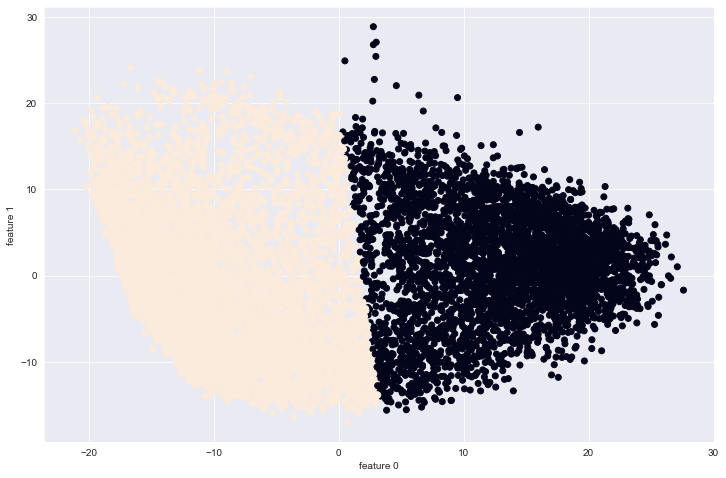

Clustering Accuracy PCA - Flatten Image (Train): 0.7107291666666666
Clustering Accuracy PCA - Flatten Image (Test): 0.2488
Loading flattened data from saved location...
Clustering the data...
encoding LDA: LatentDirichletAllocation


KeyboardInterrupt: 

In [9]:
cae_flat_pca, train_flat_benchmark_pca, test_flat_benchmark_pca = clus.train_cluster(poisoned_trainloader, trainloader, testloader, selected_classes, "flat", "pca", device, FEATURES_PATH, n_components=4)
print(f"Clustering Accuracy PCA - Flatten Image (Train): {train_flat_benchmark_pca[1]['clustering_accuracy']}")
print(f"Clustering Accuracy PCA - Flatten Image (Test): {test_flat_benchmark_pca[1]['clustering_accuracy']}")

cae_flat_lda, train_flat_benchmark_lda, test_flat_benchmark_lda = clus.train_cluster(poisoned_trainloader, trainloader, testloader, selected_classes, "flat", "lda", device, FEATURES_PATH, n_components=2)
print(f"Clustering Accuracy LDA - Flatten Image (Train): {train_flat_benchmark_lda[1]['clustering_accuracy']}")
print(f"Clustering Accuracy LDA - Flatten Image (Test): {test_flat_benchmark_lda[1]['clustering_accuracy']}")

##### Clustering with Feature Extraction
Use VGG16 to extract features from images before clustering.

Retrieve testing image features: 100%|██████████| 157/157 [00:05<00:00, 30.45it/s]


Saving feature data to disk...
Clustering the data...
Fashion MNIST - feature pca 4 Components - ACCURACY: 0.5047916666666666


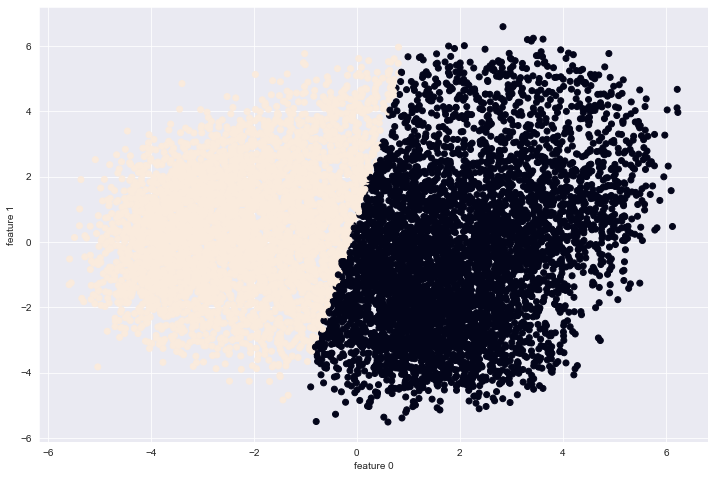

Clustering Accuracy PCA - Feature Image (Train): 0.7134375
Clustering Accuracy PCA - Feature Image (Test): 0.2199

Loading feature data from saved location...
Clustering the data...
encoding LDA: LatentDirichletAllocation


KeyboardInterrupt: 

In [10]:
cae_feature_pca, train_feature_benchmark_pca, test_feature_benchmark_pca = clus.train_cluster(poisoned_trainloader, trainloader, testloader, selected_classes, "feature", "pca", device, FEATURES_PATH, n_components=4)
print(f"Clustering Accuracy PCA - Feature Image (Train): {train_feature_benchmark_pca[1]['clustering_accuracy']}")
print(f"Clustering Accuracy PCA - Feature Image (Test): {test_feature_benchmark_pca[1]['clustering_accuracy']}")
print()
cae_feature_lda, train_feature_benchmark_lda, test_feature_benchmark_lda = clus.train_cluster(poisoned_trainloader, trainloader, testloader, selected_classes, "feature", "lda", device, FEATURES_PATH, n_components=2)
print(f"Clustering Accuracy LDA - Feature Image (Train): {train_feature_benchmark_lda[1]['clustering_accuracy']}")
print(f"Clustering Accuracy LDA - Feature Image (Test): {test_feature_benchmark_lda[1]['clustering_accuracy']}")

### Ensemble

In [5]:
from ensemble_models import train_split_models

In [6]:
avg_train_loss, avg_valid_loss, avg_valid_acc, models_class_acc = train_split_models(poisoned_dataset, testloader, selected_classes, device, epochs=10, n_splits=5)

Training model...


100%|██████████| 30/30 [00:01<00:00, 15.96it/s]


Epoch: 1/10  Training loss: 0.5702  Validation loss: 0.5894  Validation accuracy: 0.7229


100%|██████████| 30/30 [00:00<00:00, 50.08it/s]


Epoch: 2/10  Training loss: 0.5463  Validation loss: 0.5528  Validation accuracy: 0.7354


100%|██████████| 30/30 [00:00<00:00, 55.40it/s]


Epoch: 3/10  Training loss: 0.5289  Validation loss: 0.5701  Validation accuracy: 0.7396


100%|██████████| 30/30 [00:00<00:00, 50.17it/s]


Epoch: 4/10  Training loss: 0.5174  Validation loss: 0.5761  Validation accuracy: 0.7583


100%|██████████| 30/30 [00:00<00:00, 58.71it/s]


Epoch: 5/10  Training loss: 0.5123  Validation loss: 0.5637  Validation accuracy: 0.7479


100%|██████████| 30/30 [00:00<00:00, 49.30it/s]


Epoch: 6/10  Training loss: 0.5055  Validation loss: 0.5772  Validation accuracy: 0.7542


100%|██████████| 30/30 [00:00<00:00, 52.75it/s]


Epoch: 7/10  Training loss: 0.4985  Validation loss: 0.5578  Validation accuracy: 0.7500


100%|██████████| 30/30 [00:00<00:00, 51.07it/s]


Epoch: 8/10  Training loss: 0.4912  Validation loss: 0.5762  Validation accuracy: 0.7521


100%|██████████| 30/30 [00:00<00:00, 55.15it/s]


Epoch: 9/10  Training loss: 0.4773  Validation loss: 0.5674  Validation accuracy: 0.7458


100%|██████████| 30/30 [00:00<00:00, 56.71it/s]


Epoch: 10/10  Training loss: 0.4775  Validation loss: 0.5856  Validation accuracy: 0.7479
Accuracy of Dress: 86.75%
Accuracy of Coat: 48.05%
Training model...


100%|██████████| 30/30 [00:00<00:00, 37.90it/s]


Epoch: 1/10  Training loss: 0.5910  Validation loss: 0.5688  Validation accuracy: 0.7292


100%|██████████| 30/30 [00:00<00:00, 51.22it/s]


Epoch: 2/10  Training loss: 0.5605  Validation loss: 0.5491  Validation accuracy: 0.7208


100%|██████████| 30/30 [00:00<00:00, 54.38it/s]


Epoch: 3/10  Training loss: 0.5293  Validation loss: 0.5661  Validation accuracy: 0.7396


100%|██████████| 30/30 [00:00<00:00, 47.95it/s]


Epoch: 4/10  Training loss: 0.5321  Validation loss: 0.5642  Validation accuracy: 0.7375


100%|██████████| 30/30 [00:00<00:00, 54.97it/s]


Epoch: 5/10  Training loss: 0.5195  Validation loss: 0.5802  Validation accuracy: 0.7375


100%|██████████| 30/30 [00:00<00:00, 54.92it/s]


Epoch: 6/10  Training loss: 0.5157  Validation loss: 0.5496  Validation accuracy: 0.7417


100%|██████████| 30/30 [00:00<00:00, 52.82it/s]


Epoch: 7/10  Training loss: 0.5139  Validation loss: 0.5643  Validation accuracy: 0.7562


100%|██████████| 30/30 [00:00<00:00, 47.46it/s]


Epoch: 8/10  Training loss: 0.5024  Validation loss: 0.5764  Validation accuracy: 0.7542


100%|██████████| 30/30 [00:00<00:00, 42.88it/s]


Epoch: 9/10  Training loss: 0.5007  Validation loss: 0.5703  Validation accuracy: 0.7521


100%|██████████| 30/30 [00:00<00:00, 42.95it/s]


Epoch: 10/10  Training loss: 0.4872  Validation loss: 0.5737  Validation accuracy: 0.7521
Accuracy of Dress: 94.90%
Accuracy of Coat: 43.90%
Training model...


100%|██████████| 30/30 [00:00<00:00, 58.18it/s]


Epoch: 1/10  Training loss: 0.5877  Validation loss: 0.5611  Validation accuracy: 0.7354


100%|██████████| 30/30 [00:00<00:00, 56.50it/s]


Epoch: 2/10  Training loss: 0.5639  Validation loss: 0.5689  Validation accuracy: 0.7375


100%|██████████| 30/30 [00:00<00:00, 59.43it/s]


Epoch: 3/10  Training loss: 0.5295  Validation loss: 0.5748  Validation accuracy: 0.7417


100%|██████████| 30/30 [00:00<00:00, 46.12it/s]


Epoch: 4/10  Training loss: 0.5204  Validation loss: 0.5571  Validation accuracy: 0.7479


100%|██████████| 30/30 [00:00<00:00, 52.21it/s]


Epoch: 5/10  Training loss: 0.5143  Validation loss: 0.5734  Validation accuracy: 0.7583


100%|██████████| 30/30 [00:00<00:00, 41.77it/s]


Epoch: 6/10  Training loss: 0.5176  Validation loss: 0.5684  Validation accuracy: 0.7542


100%|██████████| 30/30 [00:00<00:00, 44.98it/s]


Epoch: 7/10  Training loss: 0.5100  Validation loss: 0.5638  Validation accuracy: 0.7500


100%|██████████| 30/30 [00:00<00:00, 50.06it/s]


Epoch: 8/10  Training loss: 0.4967  Validation loss: 0.5572  Validation accuracy: 0.7417


100%|██████████| 30/30 [00:00<00:00, 49.42it/s]


Epoch: 9/10  Training loss: 0.4956  Validation loss: 0.5782  Validation accuracy: 0.7521


100%|██████████| 30/30 [00:00<00:00, 42.92it/s]


Epoch: 10/10  Training loss: 0.4772  Validation loss: 0.5828  Validation accuracy: 0.7417
Accuracy of Dress: 88.60%
Accuracy of Coat: 48.55%
Training model...


100%|██████████| 30/30 [00:00<00:00, 65.38it/s]


Epoch: 1/10  Training loss: 0.5910  Validation loss: 0.5662  Validation accuracy: 0.7250


100%|██████████| 30/30 [00:00<00:00, 56.81it/s]


Epoch: 2/10  Training loss: 0.5465  Validation loss: 0.5769  Validation accuracy: 0.7250


100%|██████████| 30/30 [00:00<00:00, 49.05it/s]


Epoch: 3/10  Training loss: 0.5349  Validation loss: 0.5471  Validation accuracy: 0.7333


100%|██████████| 30/30 [00:00<00:00, 50.70it/s]


Epoch: 4/10  Training loss: 0.5242  Validation loss: 0.5482  Validation accuracy: 0.7396


100%|██████████| 30/30 [00:00<00:00, 46.18it/s]


Epoch: 5/10  Training loss: 0.5195  Validation loss: 0.5670  Validation accuracy: 0.7479


100%|██████████| 30/30 [00:00<00:00, 55.26it/s]


Epoch: 6/10  Training loss: 0.5225  Validation loss: 0.5868  Validation accuracy: 0.7500


100%|██████████| 30/30 [00:00<00:00, 39.06it/s]


Epoch: 7/10  Training loss: 0.5145  Validation loss: 0.5553  Validation accuracy: 0.7479


100%|██████████| 30/30 [00:00<00:00, 48.30it/s]


Epoch: 8/10  Training loss: 0.4978  Validation loss: 0.5730  Validation accuracy: 0.7438


100%|██████████| 30/30 [00:00<00:00, 39.45it/s]


Epoch: 9/10  Training loss: 0.5057  Validation loss: 0.5950  Validation accuracy: 0.7542


100%|██████████| 30/30 [00:00<00:00, 49.91it/s]


Epoch: 10/10  Training loss: 0.4896  Validation loss: 0.5679  Validation accuracy: 0.7500
Accuracy of Dress: 94.40%
Accuracy of Coat: 47.15%
Training model...


100%|██████████| 30/30 [00:00<00:00, 65.26it/s]


Epoch: 1/10  Training loss: 0.5864  Validation loss: 0.5579  Validation accuracy: 0.7188


100%|██████████| 30/30 [00:00<00:00, 67.10it/s]


Epoch: 2/10  Training loss: 0.5431  Validation loss: 0.5941  Validation accuracy: 0.7458


100%|██████████| 30/30 [00:00<00:00, 63.85it/s]


Epoch: 3/10  Training loss: 0.5326  Validation loss: 0.5632  Validation accuracy: 0.7312


100%|██████████| 30/30 [00:00<00:00, 64.29it/s]


Epoch: 4/10  Training loss: 0.5232  Validation loss: 0.5599  Validation accuracy: 0.7479


100%|██████████| 30/30 [00:00<00:00, 62.62it/s]


Epoch: 5/10  Training loss: 0.5090  Validation loss: 0.5524  Validation accuracy: 0.7604


100%|██████████| 30/30 [00:00<00:00, 59.77it/s]


Epoch: 6/10  Training loss: 0.5055  Validation loss: 0.5772  Validation accuracy: 0.7562


100%|██████████| 30/30 [00:00<00:00, 54.23it/s]


Epoch: 7/10  Training loss: 0.5026  Validation loss: 0.5642  Validation accuracy: 0.7521


100%|██████████| 30/30 [00:00<00:00, 52.21it/s]


Epoch: 8/10  Training loss: 0.5020  Validation loss: 0.5546  Validation accuracy: 0.7521


100%|██████████| 30/30 [00:00<00:00, 51.20it/s]


Epoch: 9/10  Training loss: 0.4892  Validation loss: 0.5573  Validation accuracy: 0.7604


100%|██████████| 30/30 [00:00<00:00, 49.90it/s]


Epoch: 10/10  Training loss: 0.4877  Validation loss: 0.5733  Validation accuracy: 0.7583
Accuracy of Dress: 88.65%
Accuracy of Coat: 49.35%


In [9]:
print(avg_train_loss, avg_valid_loss, avg_valid_acc)

0.48383030374844865 0.5766641110181808 0.75


In [8]:
models_class_acc

{0: ['Accuracy of Dress: 86.75%', 'Accuracy of Coat: 48.05%'],
 1: ['Accuracy of Dress: 94.90%', 'Accuracy of Coat: 43.90%'],
 2: ['Accuracy of Dress: 88.60%', 'Accuracy of Coat: 48.55%'],
 3: ['Accuracy of Dress: 94.40%', 'Accuracy of Coat: 47.15%'],
 4: ['Accuracy of Dress: 88.65%', 'Accuracy of Coat: 49.35%']}